# Low light image enhancement

## Import the important libraries

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

import keras
from keras import layers

import tensorflow as tf

In [2]:
# Mount the drive if needed

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Downloading the LoL dataset for training

In [3]:
!wget https://huggingface.co/datasets/geekyrakshit/LoL-Dataset/resolve/main/lol_dataset.zip
!unzip -q lol_dataset.zip && rm lol_dataset.zip

--2024-06-20 06:36:15--  https://huggingface.co/datasets/geekyrakshit/LoL-Dataset/resolve/main/lol_dataset.zip
Resolving huggingface.co (huggingface.co)... 13.33.30.49, 13.33.30.23, 13.33.30.76, ...
Connecting to huggingface.co (huggingface.co)|13.33.30.49|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/d9/09/d909ef7668bb417b7065a311bd55a3084cc83a1f918e13cb41c5503328432db2/419fddc48958cd0f5599939ee0248852a37ceb8bb738c9b9525e95b25a89de9a?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27lol_dataset.zip%3B+filename%3D%22lol_dataset.zip%22%3B&response-content-type=application%2Fzip&Expires=1719124575&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxOTEyNDU3NX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9kOS8wOS9kOTA5ZWY3NjY4YmI0MTdiNzA2NWEzMTFiZDU1YTMwODRjYzgzYTFmOTE4ZTEzY2I0MWM1NTAzMzI4NDMyZGIyLzQxOWZkZGM0ODk1OGNkMGY1NTk5OTM5ZWUwMjQ4ODUyYTM3Y2Vi

## Defining some important parameters --> can change them and see how the results are affected

In [4]:
IMAGE_SIZE = 128 # The crops that are made while loading the data
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 300 # Train size for the LoL Dataset

## Utility functions to load the dataset

In [5]:
def read_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img.set_shape([None, None, 3])
    img = tf.cast(img, dtype=tf.float32) / 255.0
    return img
def random_crop(low_light_img, enhanced_img):
    low_light_img_shape = tf.shape(low_light_img)[:2]
    low_w = tf.random.uniform(shape=(), maxval=low_light_img_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32)
    low_h = tf.random.uniform(shape=(), maxval=low_light_img_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32)
    low_light_img_cropped = low_light_img[low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE]
    enhanced_img_cropped = enhanced_img[low_h : low_h + IMAGE_SIZE, low_w : low_w + IMAGE_SIZE]
    # in order to avoid NONE during shape inference
    low_light_img_cropped.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    enhanced_img_cropped.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return low_light_img_cropped, enhanced_img_cropped

def load_data_and_preprocess(low_light_img_path, enhanced_img_path):
    low_light_img = read_image(low_light_img_path)
    enhanced_img = read_image(enhanced_img_path)
    low_light_img, enhanced_img = random_crop(low_light_img, enhanced_img)
    return low_light_img, enhanced_img


def prepare_dataset(low_light_imgs, enhanced_imgs):
    dataset = tf.data.Dataset.from_tensor_slices((low_light_imgs, enhanced_imgs))
    dataset = dataset.map(load_data_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

## Loading the LoL dataset train , val and test sets

(You can also load your own datasets with the corresponding low light and the ground truth images)

In [6]:
train_X = sorted(glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
train_Y = sorted(glob("./lol_dataset/our485/high/*"))[:MAX_TRAIN_IMAGES]

val_X = sorted(glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
val_Y = sorted(glob("./lol_dataset/our485/high/*"))[MAX_TRAIN_IMAGES:]

test_X = sorted(glob("./lol_dataset/eval15/low/*"))
test_Y = sorted(glob("./lol_dataset/eval15/high/*"))

train_dataset = prepare_dataset(train_X, train_Y)
val_dataset = prepare_dataset(val_X, val_Y)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
print("The size of the training set is:",len(train_X))
print("The size of the validation set is:",len(val_X))

The size of the training set is: 300
The size of the validation set is: 185


## Defining the functions for the model architecture

In [9]:
# Selective kernel feature fusion
def skff(multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3):
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = layers.Add()([multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3])
    gap = layers.GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = layers.Reshape((1, 1, channels))(gap)
    compact_feature_representation = layers.Conv2D(filters=channels // 8, kernel_size=(1, 1), activation="relu")(channel_wise_statistics)

    feature_descriptor_1 = layers.Conv2D(channels, kernel_size=(1, 1), activation="softmax")(compact_feature_representation)
    feature_descriptor_2 = layers.Conv2D(channels, kernel_size=(1, 1), activation="softmax")(compact_feature_representation)
    feature_descriptor_3 = layers.Conv2D(channels, kernel_size=(1, 1), activation="softmax")(compact_feature_representation)

    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3

    combined_feature = layers.Add()([feature_1, feature_2, feature_3])
    return combined_feature

# Channel pooling
class ChannelPooling(layers.Layer):
    def __init__(self, axis=-1, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.axis = axis
        self.concat = layers.Concatenate(axis=self.axis)

    def call(self, inputs):
        average_pooling = tf.expand_dims(tf.reduce_mean(inputs, axis=-1), axis=-1)
        max_pooling = tf.expand_dims(tf.reduce_max(inputs, axis=-1), axis=-1)
        return self.concat([average_pooling, max_pooling])

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})

# Spatial attention block
def sab(input_tensor):
    compressed_feature_map = ChannelPooling(axis=-1)(input_tensor)
    feature_map = layers.Conv2D(1, kernel_size=(1, 1))(compressed_feature_map)
    feature_map = keras.activations.sigmoid(feature_map)
    return input_tensor * feature_map

# Channel attention block
def cab(input_tensor):
    channels = list(input_tensor.shape)[-1]
    average_pooling = layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = layers.Reshape((1, 1, channels))(average_pooling)
    feature_activations = layers.Conv2D(filters=channels // 8, kernel_size=(1, 1), activation="relu")(feature_descriptor)
    feature_activations = layers.Conv2D(filters=channels, kernel_size=(1, 1), activation="sigmoid")(feature_activations)
    return input_tensor * feature_activations

# Dual attention unit block
def dau(input_tensor):
    channels = list(input_tensor.shape)[-1]
    feature_map = layers.Conv2D(channels, kernel_size=(3, 3), padding="same", activation="relu")(input_tensor)
    feature_map = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(feature_map)
    channel_attention = cab(feature_map)
    spatial_attention = sab(feature_map)
    concatenation = layers.Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return layers.Add()([input_tensor, concatenation])

# Down sampling
def down_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(input_tensor)
    main_branch = layers.Conv2D(channels, kernel_size=(3, 3), padding="same", activation="relu")(main_branch)
    main_branch = layers.MaxPooling2D()(main_branch)
    main_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.MaxPooling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])

# Up sampling
def up_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(input_tensor)
    main_branch = layers.Conv2D(channels, kernel_size=(3, 3), padding="same", activation="relu")(main_branch)
    main_branch = layers.UpSampling2D()(main_branch)
    main_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.UpSampling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])

# Multi scale residual Block
def mrb(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    # DAU
    level1_dau = dau(level1)
    level2_dau = dau(level2)
    level3_dau = dau(level3)
    # SKFF
    level1_skff = skff(
        level1_dau,
        up_sampling_module(level2_dau),
        up_sampling_module(up_sampling_module(level3_dau)),
    )
    level2_skff = skff(
        down_sampling_module(level1_dau),
        level2_dau,
        up_sampling_module(level3_dau),
    )
    level3_skff = skff(
        down_sampling_module(down_sampling_module(level1_dau)),
        down_sampling_module(level2_dau),
        level3_dau,
    )
    # DAU 2
    level1_dau_2 = dau(level1_skff)
    level2_dau_2 = up_sampling_module((dau(level2_skff)))
    level3_dau_2 = up_sampling_module(up_sampling_module(dau(level3_skff)))
    # SKFF 2
    skff_ = skff(level1_dau_2, level2_dau_2, level3_dau_2)
    conv = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(skff_)
    return layers.Add()([input_tensor, conv])


# Recursive residual group
def rrg(input_tensor, num_mrb, channels):
    conv1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_mrb):
        conv1 = mrb(conv1, channels)
    conv2 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(conv1)
    return layers.Add()([conv2, input_tensor])

## Defining the final model by combining the architecture

In [10]:
def custom_mirnet_model(num_rrg, num_mrb, channels):
    input_tensor = keras.Input(shape=[None, None, 3])
    x1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_rrg):
        x1 = rrg(x1, num_mrb, channels)
    conv = layers.Conv2D(3, kernel_size=(3, 3), padding="same")(x1)
    output_tensor = layers.Add()([input_tensor, conv])
    return keras.Model(input_tensor, output_tensor)

## Defining the loss and metrics for the training process

In [11]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)

## Add optimizer and compile the model

In [12]:
model = custom_mirnet_model(num_rrg=3, num_mrb=2, channels=64)

optimizer = keras.optimizers.Adam(learning_rate=1e-4)

model.compile(
    optimizer=optimizer,
    loss=charbonnier_loss,
    metrics=[peak_signal_noise_ratio],
)

## Start the training process

Epoch 1/50
75/75 [==============================] - 368s 1s/step - loss: 0.1994 - peak_signal_noise_ratio: 62.2670 - val_loss: 0.1280 - val_peak_signal_noise_ratio: 65.4707 - lr: 1.0000e-04
Epoch 2/50
75/75 [==============================] - 104s 1s/step - loss: 0.1665 - peak_signal_noise_ratio: 63.5521 - val_loss: 0.1251 - val_peak_signal_noise_ratio: 65.8120 - lr: 1.0000e-04
Epoch 3/50
75/75 [==============================] - 103s 1s/step - loss: 0.1619 - peak_signal_noise_ratio: 63.7957 - val_loss: 0.1218 - val_peak_signal_noise_ratio: 65.8752 - lr: 1.0000e-04
Epoch 4/50
75/75 [==============================] - 103s 1s/step - loss: 0.1613 - peak_signal_noise_ratio: 63.6729 - val_loss: 0.1217 - val_peak_signal_noise_ratio: 66.1049 - lr: 1.0000e-04
Epoch 5/50
75/75 [==============================] - 103s 1s/step - loss: 0.1688 - peak_signal_noise_ratio: 63.6215 - val_loss: 0.1168 - val_peak_signal_noise_ratio: 66.4673 - lr: 1.0000e-04
Epoch 6/50
75/75 [==============================] 

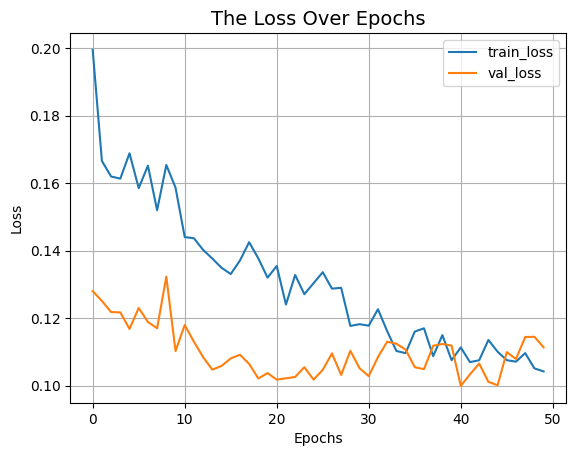

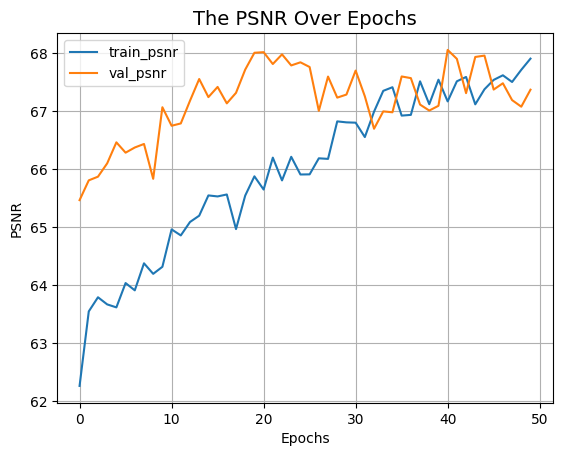

In [13]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs = 50,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_peak_signal_noise_ratio",
            factor=0.5,
            patience=5,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        )
    ],
)


def plot_history(value, name):
    plt.plot(history.history[value], label=f"train_{name.lower()}")
    plt.plot(history.history[f"val_{value}"], label=f"val_{name.lower()}")
    plt.xlabel("Epochs")
    plt.ylabel(name)
    plt.title(f"The {name} Over Epochs", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss", "Loss")
plot_history("peak_signal_noise_ratio", "PSNR")

## Save the model weights

In [14]:
# Save the model weights
model.save_weights('/content/drive/MyDrive/mirnet_wts.h5')

## Perform inference on some test images

In [15]:
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

def infer(original_img):
    img = keras.utils.img_to_array(original_img)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)
    output = model.predict(img, verbose=0)
    output_img = output[0] * 255.0
    output_img = output_img.clip(0, 255)
    output_img = output_img.reshape(
        (np.shape(output_img)[0], np.shape(output_img)[1], 3)
    )
    output_img = Image.fromarray(np.uint8(output_img))
    original_img = Image.fromarray(np.uint8(original_img))
    return output_img

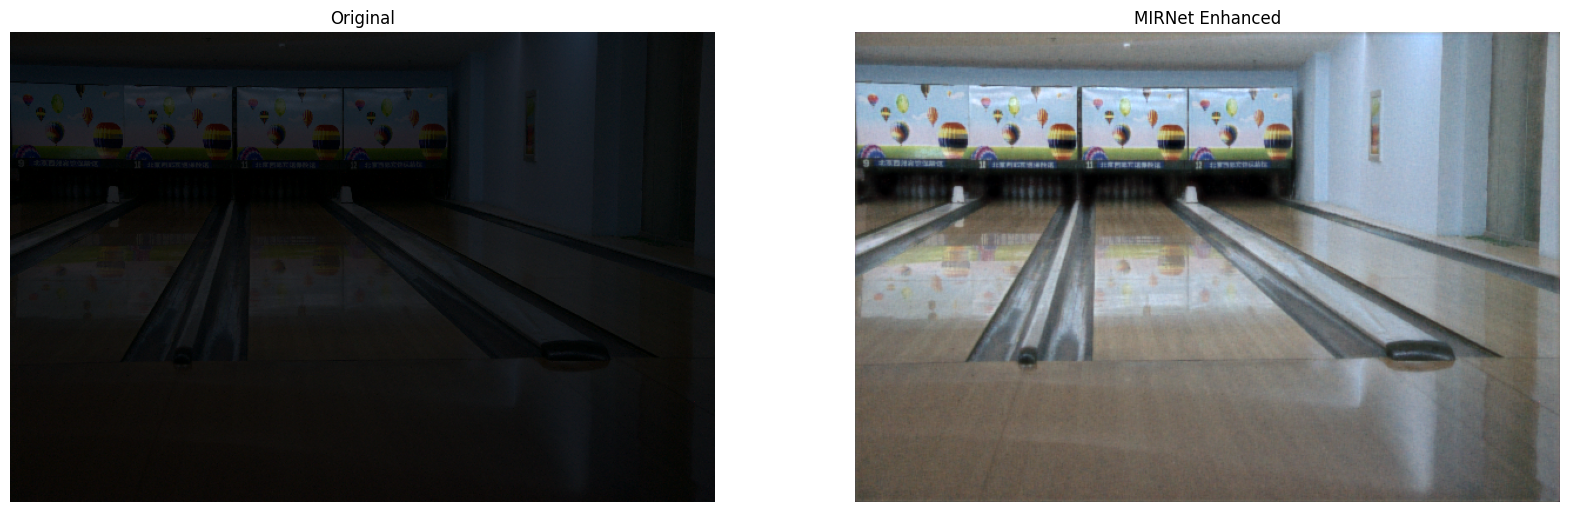

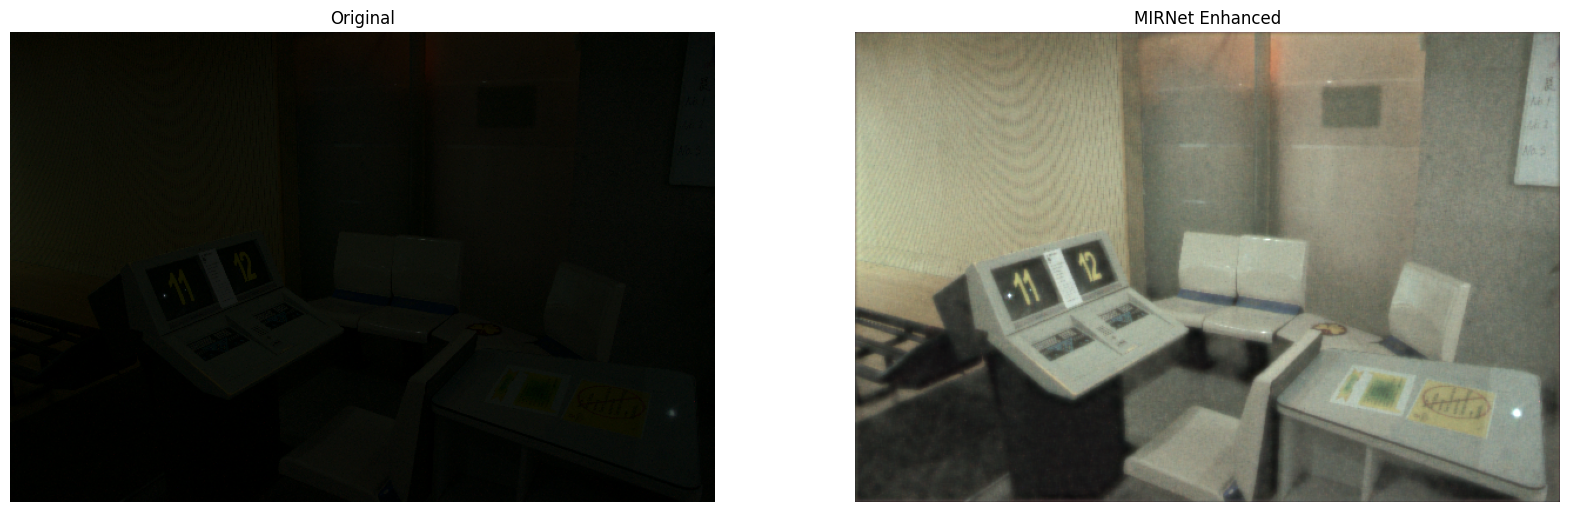

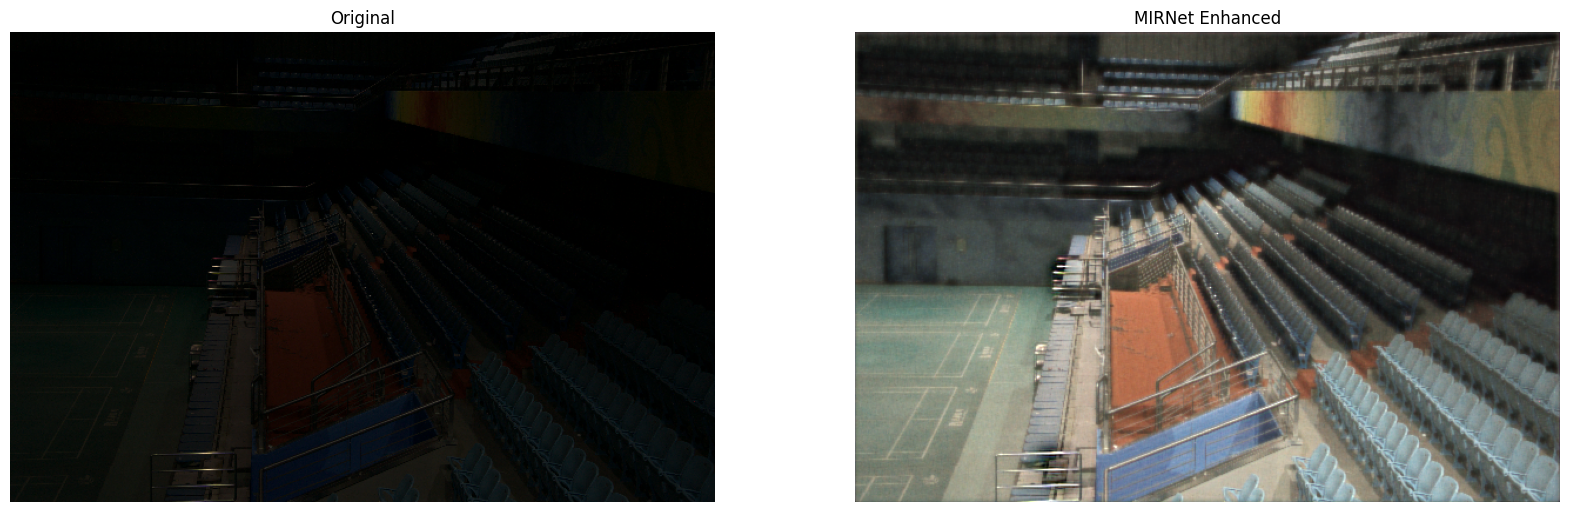

In [16]:
for low_light_img in random.sample(test_X, 3):
    original_img = Image.open(low_light_img)
    original_img = original_img.convert('RGB')
    original_shape = original_img.size
    original_img = original_img.resize((600,400))

    enhanced_img = infer(original_img)
    enhanced_img = enhanced_img.resize(original_shape)

    original_img = original_img.resize(original_shape)

    plot_results(
        [original_img, enhanced_img],
        ["Original", "MIRNet Enhanced"],
        (20,12),
    )

## Calculate the metrices psnr, mae and mse

In [22]:
def calculate_metrics_for_imgs(firstImage, secondImage):
   diff = np.subtract(firstImage, secondImage)
   mae = np.mean(np.abs(diff))
   squared_diff = np.square(diff)
   mse = np.mean(squared_diff)
   max_pixel = 255
   psnr = 20 * np.log10(max_pixel) - 10 * np.log10(mse)
   return mae, mse, psnr

In [23]:
!mkdir -p '/content/save_files/train'
!mkdir -p '/content/save_files/val'
!mkdir -p '/content/save_files/test'

In [24]:
# First lets save the results obtained in a folder named save_files ---> you can change where you want to save
def save_files_for_eval(img_files, save_dir):
  for low_light_img in img_files:
      file_name = (low_light_img).split('/')[-1].split('.')[0]
      original_img = Image.open(low_light_img)
      original_img = original_img.convert('RGB')
      original_shape = original_img.size
      original_img = original_img.resize((600,400))

      output_file_name = file_name + '.png'

      output_file_path = os.path.join(save_dir, output_file_name)
      high_light_img = infer(original_img)
      high_light_img = high_light_img.resize(original_shape)
      high_light_img.save(output_file_path)

  print("Process completed")

In [ ]:
save_files_for_eval(train_X, '/content/save_files/train')
save_files_for_eval(val_X, '/content/save_files/val')
save_files_for_eval(test_X, '/content/save_files/test')

In [19]:
def calculate_metrics_for_set(enhanced_img_files_path, ground_truth_files_path, type_dataset):
    total_mae = 0
    total_mse = 0
    total_psnr = 0

    cnt = 0

    if(type_dataset == "train"):
        img_files_list = sorted([file for file in os.listdir(ground_truth_files_path) if not file.split('/')[-1].startswith('.')])[:MAX_TRAIN_IMAGES]
    elif(type_dataset == "val"):
        img_files_list = sorted([file for file in os.listdir(ground_truth_files_path) if not file.split('/')[-1].startswith('.')])[MAX_TRAIN_IMAGES:]
    elif(type_dataset == "test"):
        img_files_list = sorted([file for file in os.listdir(ground_truth_files_path) if not file.split('/')[-1].startswith('.')])
    else:
      print("Invalid type dataset")
      return


    for enhanced_img, ground_truth_img in list(zip(sorted([file for file in os.listdir(enhanced_img_files_path) if not file.split('/')[-1].startswith('.')]), img_files_list)):
        enhanced_img = Image.open(os.path.join(enhanced_img_files_path, enhanced_img))
        ground_truth_img = Image.open(os.path.join(ground_truth_files_path, ground_truth_img))

        mae, mse, psnr = calculate_metrics_for_imgs(np.array(enhanced_img), np.array(ground_truth_img))

        total_mae += mae
        total_mse += mse
        total_psnr += psnr

        if(cnt%50 == 0):
          print(cnt)

        cnt+=1


    num = len(img_files_list)

    print("The mae for",type_dataset,"dataset is:",total_mae/num)
    print("The mse for",type_dataset,"dataset is:",total_mse/num)
    print("The psnr for",type_dataset,"dataset is:",total_psnr/num)

In [ ]:
calculate_metrics_for_set('/content/save_files/train', '/content/lol_dataset/our485/high', 'train')
print('---------------------------------')
calculate_metrics_for_set('/content/save_files/val', '/content/lol_dataset/our485/high', 'val')
print('---------------------------------')
calculate_metrics_for_set('/content/save_files/test', '/content/lol_dataset/eval15/high', 'test')
print('---------------------------------')

## Load the model with the pretrained weights

(before loading the weights, please run the code blocks from beginning upto the `Defining loss and metrics for training` section)

In [ ]:
#Run the inference function again

def infer(original_img):
    img = keras.utils.img_to_array(original_img)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)
    output = model.predict(img, verbose=0)
    output_img = output[0] * 255.0
    output_img = output_img.clip(0, 255)
    output_img = output_img.reshape(
        (np.shape(output_img)[0], np.shape(output_img)[1], 3)
    )
    output_img = Image.fromarray(np.uint8(output_img))
    original_img = Image.fromarray(np.uint8(original_img))
    return output_img

In [ ]:
!gdown 1T5uFefHRHy02lcU1C8PfC3knTTnZ85ru

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

model = custom_mirnet_model(num_rrg=3, num_mrb=2, channels=64)
# Load the model weights
model.load_weights("/content/mirnet_wts.h5")

# Compile the model (necessary if you want to continue training or evaluate)
model.compile(
    optimizer=optimizer,
    loss=charbonnier_loss,
    metrics=[peak_signal_noise_ratio],
)

In [ ]:
# Use the above functions in the calculate metrics section to calculate the metrics for your custom datasets

In [ ]:
# Create a list of img files of your custom dataset

dir_path = './test/low'

img_files = [os.path.join(dir_path, img_path) for img_path in os.listdir(dir_path)]

In [ ]:
!mkdir -p './custom_files_save'

In [ ]:
save_files_for_eval(img_files, './custom_files_save')